In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = 'darkgrid')

# <center>Explore Database</center>

In [3]:
import pymysql
connection = pymysql.connect(host = 'localhost',
                             port = 3306,
                             user = 'root',
                             password = 'awzse123',
                             db = 'RFM',
                             local_infile = 1,
                             charset = 'utf8')
cursor = connection.cursor()
cursor.execute('SHOW TABLES')

# Acquire data from Database
sql = '''SELECT * FROM rfm'''
ecommerce = pd.read_sql(sql, connection)
connection.close()
ecommerce.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
ecommerce.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Delete duplicate rows
ecommerce = ecommerce[~ecommerce.duplicated()]
# Count Distinct for each column
ecommerce.nunique()

InvoiceNo      25900
StockCode       4070
Description     4224
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4373
Country           38
dtype: int64

In [6]:
# Check Missing Values
# When import to MySQL, null has been changed to '', we changed back to np.nan
ecommerce = ecommerce.replace(to_replace = r'^\s*$',value = np.nan,regex = True)
ecommerce.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

# <center>Explore Data by Columns</center>

## Check InvoiceNo Column

In [7]:
# Check how many InvoiceNo only contains numbers
invoice_num_with_str = ecommerce[~ecommerce.InvoiceNo.str.isnumeric()].shape[0]
print(str(invoice_num_with_str) + ' InvoiceNo records contain not only numbers.')

# InvoiceNo starts with 'C'
invoice_num_with_c = ecommerce[ecommerce.InvoiceNo.str.startswith('C')].shape[0]
print(str(invoice_num_with_c) + ' of them start with "C".')

max_quantity_for_c = ecommerce[ecommerce.InvoiceNo.str.startswith('C')]['Quantity'].astype(int).max()
print('The max quantity among InvoiceNo is ' + str(max_quantity_for_c) 
      + ', so InvoiceNo starting with "C" relates to transactions that lower the income.')

# Check the remaining three InvoiceNo
print('The remaining 3 records of InvoiceNo starting with "A" records the Adjusted bad debt.')
ecommerce[(~ecommerce.InvoiceNo.str.isnumeric()) & (~ecommerce.InvoiceNo.str.startswith('C'))]

9254 InvoiceNo records contain not only numbers.
9251 of them start with "C".
The max quantity among InvoiceNo is -1, so InvoiceNo starting with "C" relates to transactions that lower the income.
The remaining 3 records of InvoiceNo starting with "A" records the Adjusted bad debt.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


<body> Each InoviceNo should be one transaction, and we expect a one-to-one relationship between InvoiceNo and CustomerID. We also expect a one-to-one relationship between InvoiceNo and InvoiceDate, and a one-to-many relationship between StockCode and InvoiceNo <body/> 

In [8]:
# Check items that are recorded in the same Invoice
same_items = ecommerce.drop(columns = 'Quantity')
print( 'There are ' 
      + str(same_items[same_items.duplicated()].shape[0]) 
      + ' items that are recorded on the same Invoice twice or more.')

# Combine these items in one row so each item is unique in one Invoice
ecommerce = ecommerce.fillna('NaN')
ecommerce = ecommerce.groupby(by = ['InvoiceNo',
                                    'StockCode',
                                    'Description',
                                    'InvoiceDate',
                                    'UnitPrice',
                                    'CustomerID',
                                    'Country']).agg({'Quantity':'sum'})
ecommerce = ecommerce.reset_index(['InvoiceNo',
                                   'StockCode', 
                                   'Description', 
                                   'InvoiceDate', 
                                   'UnitPrice', 
                                   'CustomerID', 
                                   'Country']).replace('NaN',np.nan)
ecommerce

There are 4833 items that are recorded on the same Invoice twice or more.


,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,4.25,17850,United Kingdom,6
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,7.65,17850,United Kingdom,2
2,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850,United Kingdom,6
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850,United Kingdom,6
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850,United Kingdom,6
...,...,...,...,...,...,...,...,...
531803,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,2011-12-09 09:57:00,0.83,14397,United Kingdom,-11
531804,C581499,M,Manual,2011-12-09 10:28:00,224.69,15498,United Kingdom,-1
531805,C581568,21258,VICTORIAN SEWING BOX LARGE,2011-12-09 11:57:00,10.95,15311,United Kingdom,-5
531806,C581569,20979,36 PENCILS TUBE RED RETROSPOT,2011-12-09 11:58:00,1.25,17315,United Kingdom,-5


In [9]:
# Check validation of the relationships between InvoiceNo and CustomerID
n_customerID_per_invoiceNo = ecommerce[['InvoiceNo','CustomerID']].drop_duplicates()\
                                                                  .groupby('InvoiceNo')\
                                                                  .agg({'CustomerID':'count'})
n_invoiceNo_per_customerID = ecommerce[['InvoiceNo','CustomerID']].drop_duplicates()\
                                                                  .groupby('CustomerID')\
                                                                  .agg({'InvoiceNo':'count'})
print('There are ' + str(ecommerce.InvoiceNo.nunique()) +' transactions.')
if n_customerID_per_invoiceNo.CustomerID.max() == 1 and n_invoiceNo_per_customerID.InvoiceNo.max() > 1:
    print('Each transaction(InvoiceNo) has only 1 customer and each customer may have more than 1 transaction.')
else:
    print('There might be wrong records of InvocieNo or CustomerID')

# Check validation of relationships between InvoiceNo and InvoiceDate
n_invoiceDate_per_invoiceNo = ecommerce[['InvoiceNo','InvoiceDate']].drop_duplicates()\
                                                                    .groupby('InvoiceNo')\
                                                                    .agg({'InvoiceDate':'count'})

if n_invoiceDate_per_invoiceNo.InvoiceDate.max() == 1:
    print('Each transaction(InvoiceNo) has only 1 InvoiceDate.')
else:
    print('Records show that each transactions(InvoiceNo) may has '
          +  str(n_invoiceDate_per_invoiceNo.InvoiceDate.max())
          + ' InvoiceDate(Time) at most.')

There are 25900 transactions.
Each transaction(InvoiceNo) has only 1 customer and each customer may have more than 1 transaction.
Records show that each transactions(InvoiceNo) may has 2 InvoiceDate(Time) at most.


In [10]:
# Create a New_InvoiceDate column to validate the relationship between InoviceNo and InvoiceDate
invoiceNo_date_relation = ecommerce[['InvoiceNo','InvoiceDate']].drop_duplicates()
invoiceNo_date_relation = invoiceNo_date_relation[invoiceNo_date_relation.InvoiceNo\
                                                                         .duplicated()]\
                                                                         .set_index('InvoiceNo')\
                                                                         .InvoiceDate\
                                                                         .to_dict()
ecommerce['New_InvoiceDate'] = ecommerce.InvoiceNo.apply(lambda x: invoiceNo_date_relation[x]
                                                         if x in invoiceNo_date_relation
                                                         else pd.NaT)

ecommerce['New_InvoiceDate'] = ecommerce['New_InvoiceDate'].fillna(pd.to_datetime(ecommerce.InvoiceDate))

## Check StockCode Column

<body> We noticed that StockCode is numeric and some may contain letters, StockCode ends with a letter are a sub-category of an item while some StockCode only contain letters. In this section, we will re-assign a cateogry to group sub-categories together and assign a NaN to items that has no business meaning in our analysis<body/> 

In [11]:
# StockCode that starts with a letter
stockcode_starts_with_letter = ecommerce[ecommerce.StockCode.str.contains('^[a-zA-Z]')].StockCode\
                                                                                       .value_counts()\
                                                                                       .index\
                                                                                       .to_list()
invaid_stockcode = []
for i in stockcode_starts_with_letter:
    if not i.startswith('DCGS'):
        invaid_stockcode.append(i)

print("StockCode that starts with a letter includes: \n" + str(stockcode_starts_with_letter))
ecommerce.loc[ecommerce.StockCode.isin(stockcode_starts_with_letter)] = ecommerce
print('StockCode that has no business meaning for our analysis includes: \n' + str(invaid_stockcode))

# StockCode that ends with a letter
stockcode_ends_with_letter = ecommerce[ecommerce.StockCode.str.contains('[a-zA-Z]$') 
                                       & (~ecommerce.StockCode.isin(invaid_stockcode))].StockCode\
                                                                                       .value_counts()\
                                                                                       .index\
                                                                                       .to_list()

classificaiton = []
items_in_same_class = {}
for i in stockcode_ends_with_letter:
    code = ''
    letter = ''
    for l in i:
        if ord(l) <= ord('9') and ord(l) >= ord('0'):
            code += l
        elif not (ord(l) >= ord('a') and ord(l) <= ord('z') 
                  or ord(l) >= ord('A') and ord(l) <= ord('Z')
                 ):
            print(i) # print strange StockCode
    if i not in items_in_same_class:
        items_in_same_class[i] = code
    else:
        items_in_same_class[i].append(code)

# Create a New_StockCode column that re-classify each StockCode
ecommerce['New_StockCode'] = ecommerce['StockCode']
ecommerce = ecommerce.replace({'New_StockCode':items_in_same_class})
ecommerce.loc[ecommerce.StockCode.str.isalpha(),'New_StockCode'] = ecommerce.StockCode

# Assign 'NaN' to rows that has business meaning for our analysis
ecommerce.loc[ecommerce.StockCode.isin(invaid_stockcode), 'New_StockCode'] = np.nan

StockCode that starts with a letter includes: 
['POST', 'DOT', 'M', 'C2', 'D', 'S', 'BANK CHARGES', 'AMAZONFEE', 'CRUK', 'DCGSSGIRL', 'DCGSSBOY', 'gift_0001_20', 'gift_0001_10', 'gift_0001_30', 'DCGS0003', 'PADS', 'gift_0001_50', 'gift_0001_40', 'B', 'DCGS0069', 'DCGS0070', 'DCGS0076', 'm', 'DCGS0066P', 'DCGS0073', 'DCGS0057', 'DCGS0074', 'DCGS0072', 'DCGS0068', 'DCGS0071', 'DCGS0055', 'DCGS0004', 'DCGS0067']
StockCode that has no business meaning for our analysis includes: 
['POST', 'DOT', 'M', 'C2', 'D', 'S', 'BANK CHARGES', 'AMAZONFEE', 'CRUK', 'gift_0001_20', 'gift_0001_10', 'gift_0001_30', 'PADS', 'gift_0001_50', 'gift_0001_40', 'B', 'm']


## Check Description Column

In [12]:
# change datatype of Description to str and delete left/right space
ecommerce['Description'] = ecommerce.Description.str.strip()
ecommerce['New_Description'] = ecommerce.Description.astype(str).replace('nan',np.nan)
# Find all the Description that contains only 1 or 0 words
description_classification = ecommerce.New_Description.dropna().unique().tolist()
one_word_description = []
for i in description_classification:
    if i != np.nan:
        if ' ' not in i and i != '':
             one_word_description.append(i)
print(one_word_description)

['POSTAGE', 'CARRIAGE', 'Manual', 'amazon', '?', 'SOMBRERO', 'check', 'damages', 'faulty', 'Found', 'found', 'counted', 'Dotcom', 'samples/damages', 'showroom', 'MIA', 'Adjustment', 'damages/display', 'broken', '?lost', 'damages?', 'cracked', 'Damaged', 'SAMPLES', 'damaged', 'DAMAGED', 'Display', 'Missing', 'adjustment', 'returned', 'adjust', 'crushed', 'samples', 'mailout', 'wet/rusty', 'damages/dotcom?', 'smashed', 'missing', 'FOUND', 'dotcom', 'FBA', 'ebay', 'Damages/samples', '?display?', '?missing', 'Crushed', 'test', '??', 'Amazon', 'Dagamed', 'WET/MOULDY', 'mouldy', 're-adjustment', 'Breakages', '20713', 'Damages', 'CHECK', 'missing?', '???lost', 'dotcomstock', 'check?', '????missing', '???missing', 'AMAZON', 'wet?', 'lost??', '???', 'wet', '????damages????', 'lost', 'Discount']


In [13]:
# Change the typo in New_Description/ Standardize the New_Description
ecommerce['New_Description'] = ecommerce.Description.astype(str).apply(lambda x: x.upper())

ecommerce.loc[((ecommerce.New_Description == '??') | (ecommerce.New_Description == '???')),'New_Description'] = '?'
ecommerce.loc[ecommerce.New_Description =='?DISPLAY?', 'New_Description'] = 'DISPLAY?'
ecommerce.loc[((ecommerce.New_Description.str.contains('MISS')) 
               & (ecommerce.New_Description.str.contains('?',regex=False))),'New_Description'] = 'MISSING?'
ecommerce.loc[((ecommerce.New_Description.str.contains('LOST')) 
               & (ecommerce.New_Description.str.contains('?',regex=False))),'New_Description'] = 'LOST?'
ecommerce.loc[((ecommerce.New_Description.str.contains('DAMAGES')) 
               & (~ecommerce.New_Description.str.contains('/',regex=False))),'New_Description']= 'DAMAGED'

#Change 'NAN' to np.nan back
ecommerce.New_Description = ecommerce.New_Description.replace('NAN',np.nan)

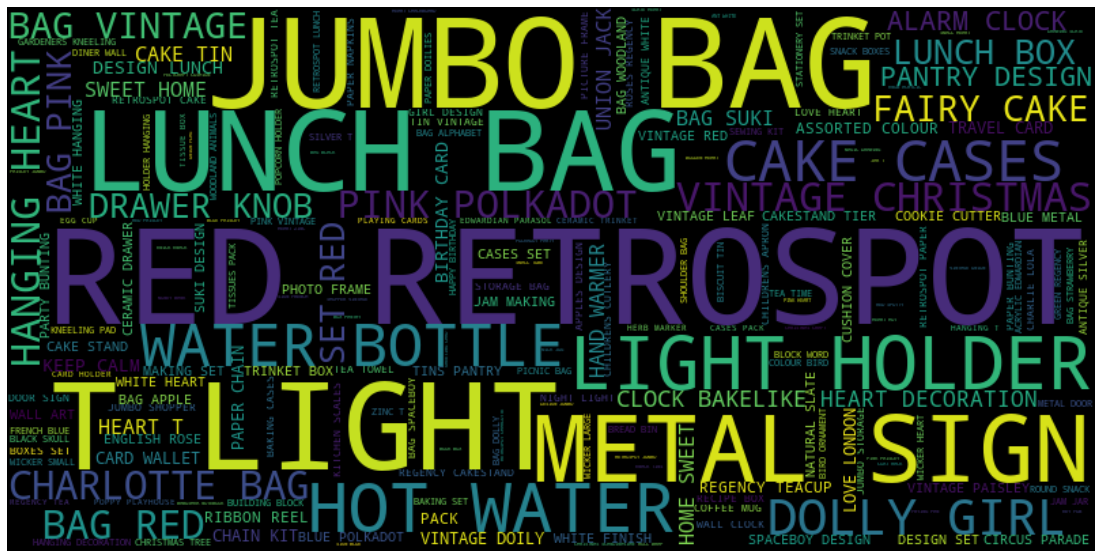

In [14]:
# Word Cloud for Descriptions
from wordcloud import WordCloud
all_words = ' '.join(ecommerce.dropna(subset = ['New_Description']).New_Description)
wordcloud = WordCloud(width=800, height=400).generate(all_words)
plt.figure( figsize = (20,10) )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Relationship between Stock Code and Description

In [15]:
# Build a dictionary that reflect possible description for each Stock Code:
stock_code_dict = ecommerce.groupby('StockCode')['New_Description'].apply(list).to_dict()
stock_code_description = stock_code_dict.copy()

for i in stock_code_description:
    stock_code_description[i] = []

for i in stock_code_dict:
    l = []
    for j in stock_code_dict[i]:
        if j not in l:
            l.append(j)
            stock_code_description[i].append(j)

# remove np.nan description from dictionary
for i in stock_code_description:
    if stock_code_description[i] == [np.nan]:
        stock_code_description[i] = np.nan
    else:
        if np.nan in stock_code_description[i]:
            stock_code_description[i].remove(np.nan)
            
stock_code_description

# Add a new column to put all descriptions for Stock Code
ecommerce['Description_List'] = ecommerce['StockCode'].map(stock_code_description)

## Check Country column

In [16]:
# EIRE are not formal name, RSA is Abbreviation for South Africa, and Unspecified should be changed to null.
country_formal = {'EIRE':'Ireland', 'RSA':'South Africa', 'Unspecified':np.nan}
ecommerce['Country'] = ecommerce['Country'].replace(country_formal)

print('Customers are from ' 
      + str(len(ecommerce.Country.dropna().unique())) 
      + ' Countires: ' 
      + str(ecommerce.Country.dropna().unique()))


Customers are from 37 Countires: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'Ireland' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Finland' 'Austria' 'Bahrain' 'Israel' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Brazil' 'USA' 'European Community' 'Malta'
 'South Africa']


## Create Columns for Key Information

In [17]:
# Add Columns for transaction Year_Month/Date/Year/Month/Day_of_week/Hour
ecommerce['Year_Month'] = ecommerce.New_InvoiceDate.dt.to_period('M')
ecommerce['Date'] = ecommerce.New_InvoiceDate.dt.to_period('D')
ecommerce['Year'] = ecommerce.New_InvoiceDate.dt.year
ecommerce['Month'] = ecommerce.New_InvoiceDate.dt.month
ecommerce['Day_of_Week'] = ecommerce.New_InvoiceDate.dt.dayofweek + 1 # Monday = 0
ecommerce['Hour'] = ecommerce.New_InvoiceDate.dt.hour
# Add Columns Amount, Days_since_Transaction
ecommerce['Amount'] = ecommerce['UnitPrice'] * ecommerce['Quantity']
max_date = max(ecommerce['InvoiceDate'])
ecommerce['Days_since_Transaction'] = (max_date - ecommerce.New_InvoiceDate).dt.days + 1
# Add Columns Discount_Transation (1: Discount, 2: Not Discount) Refund_Transaction(1:Refund, 2: Not Refund)
ecommerce['Discount_Transaction'] = ecommerce.StockCode.apply(lambda x: 1 if x == 'D' else 0)
ecommerce['Refund_Transaction'] = ecommerce.Quantity.apply(lambda x: 1 if x < 0 else 0)
ecommerce.head()

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Quantity,New_InvoiceDate,New_StockCode,...,Year_Month,Date,Year,Month,Day_of_Week,Hour,Amount,Days_since_Transaction,Discount_Transaction,Refund_Transaction
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,4.25,17850,United Kingdom,6,2010-12-01 08:26:00,21730,...,2010-12,2010-12-01,2010,12,3,8,25.50,374,0,0
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,7.65,17850,United Kingdom,2,2010-12-01 08:26:00,22752,...,2010-12,2010-12-01,2010,12,3,8,15.30,374,0,0
2,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850,United Kingdom,6,2010-12-01 08:26:00,71053,...,2010-12,2010-12-01,2010,12,3,8,20.34,374,0,0
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850,United Kingdom,6,2010-12-01 08:26:00,84029,...,2010-12,2010-12-01,2010,12,3,8,20.34,374,0,0
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850,United Kingdom,6,2010-12-01 08:26:00,84029,...,2010-12,2010-12-01,2010,12,3,8,20.34,374,0,0


In [18]:
# Check data types and transfer data type
ecommerce.Description = ecommerce.Description.astype(str).replace('nan',np.nan)
ecommerce.New_Description = ecommerce.New_Description.astype(str).replace('nan',np.nan)
ecommerce.InvoiceNo = ecommerce.InvoiceNo.astype(str).replace('nan',np.nan)
ecommerce.CustomerID = ecommerce.CustomerID.astype(str).replace('nan',np.nan)
ecommerce.Year = ecommerce.Year.astype(int)
ecommerce.Month = ecommerce.Month.astype(int)
ecommerce.Day_of_Week = ecommerce.Day_of_Week.astype(int)
ecommerce.Hour = ecommerce.Hour.astype(int)
ecommerce.dtypes

InvoiceNo                         object
StockCode                         object
Description                       object
InvoiceDate               datetime64[ns]
UnitPrice                        float64
CustomerID                        object
Country                           object
Quantity                           int64
New_InvoiceDate           datetime64[ns]
New_StockCode                     object
New_Description                   object
Description_List                  object
Year_Month                     period[M]
Date                           period[D]
Year                               int64
Month                              int64
Day_of_Week                        int64
Hour                               int64
Amount                           float64
Days_since_Transaction             int64
Discount_Transaction               int64
Refund_Transaction                 int64
dtype: object

# <center>Explorative Data Analysis</center>

<body> The original data is in the format that each row stands for one type of item in one transaction, we will extract the necessary information and store the information into a new table where one row represents one transaction <body/>

In [19]:
# Data Preparation
ecommerce_new = ecommerce.fillna('NaN')\
                         .groupby(['InvoiceNo', 'CustomerID', 
                                   'New_InvoiceDate', 
                                   'Country',
                                   'Year',
                                   'Month', 
                                   'Day_of_Week',
                                   'Hour',
                                   'Days_since_Transaction']).agg({'Amount':'sum',
                                                                   'StockCode':(lambda x: tuple(x.to_list()))})
ecommerce_new = ecommerce_new.reset_index().replace('NaN',np.nan)                              
ecommerce_new = ecommerce_new[~ecommerce_new.duplicated()]

ecommerce_new.head()


,InvoiceNo,CustomerID,New_InvoiceDate,Country,Year,Month,Day_of_Week,Hour,Days_since_Transaction,Amount,StockCode
0,536365,17850,2010-12-01 08:26:00,United Kingdom,2010,12,3,8,374,139.12,"(21730, 22752, 71053, 84029E, 84029G, 84406B, ..."
1,536366,17850,2010-12-01 08:28:00,United Kingdom,2010,12,3,8,374,22.20,"(22632, 22633)"
2,536367,13047,2010-12-01 08:34:00,United Kingdom,2010,12,3,8,374,278.73,"(21754, 21755, 21777, 22310, 22622, 22623, 227..."
3,536368,13047,2010-12-01 08:34:00,United Kingdom,2010,12,3,8,374,70.05,"(22912, 22913, 22914, 22960)"
4,536369,13047,2010-12-01 08:35:00,United Kingdom,2010,12,3,8,374,17.85,"(21756,)"


In [20]:
# Save Data for future usage
ecommerce.to_csv('ecommerce_cleaned.csv')
ecommerce_new.to_csv('ecommerce_new.csv')

## Country Analysis

<body> In this section, we will conduct a country analysis to see sales, customer, and transaction distributions in each country. <body/>

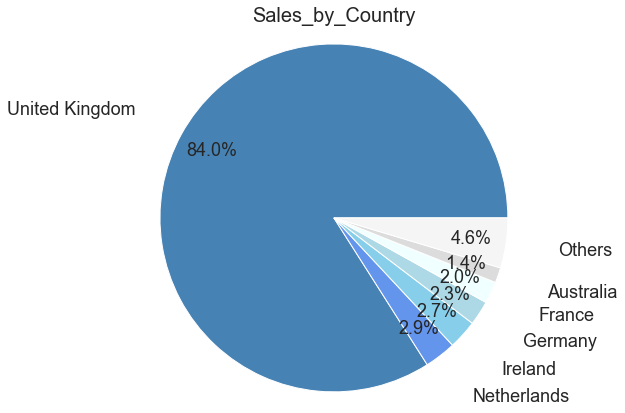

In [21]:
# Sales by Country
Sales_by_Country = ecommerce.groupby(by = 'Country').agg({'Amount':'sum'})
Sales_by_Country = Sales_by_Country.sort_values('Amount',ascending = False)
Sales_by_Country['Percentage'] = Sales_by_Country.Amount/sum(Sales_by_Country.Amount)
Sales_by_Country_Significant = Sales_by_Country[Sales_by_Country.Percentage >= 0.01]
# Combine all other countries 
Sales_by_Country_Others = Sales_by_Country[Sales_by_Country.Percentage < 0.01]
Others = {'Amount':sum(Sales_by_Country_Others.Amount),
          'Percentage':sum(Sales_by_Country_Others.Percentage)}
Others_index = {'Others'}
Others = pd.DataFrame(Others, index = Others_index)
# New DataFrame for analyzing Sales by Country
Sales_by_Country_Significant = Sales_by_Country_Significant.append(Others)
# pie plot
colors = ['steelblue', 'cornflowerblue', 'skyblue', 'lightblue', 'azure', 'gainsboro', 'whitesmoke']
fig, ax = plt.subplots(figsize = (5,5))
plt.pie(Sales_by_Country_Significant.Amount, 
        autopct = '%.1f%%',  
        textprops = {'fontsize': 18},
        labeldistance = 1.3, 
        pctdistance = 0.8, 
        labels = Sales_by_Country_Significant.index,
        colors = colors,
        radius = 1.6)

plt.title('Sales_by_Country',y = 1.2,fontsize = 20)
plt.show()

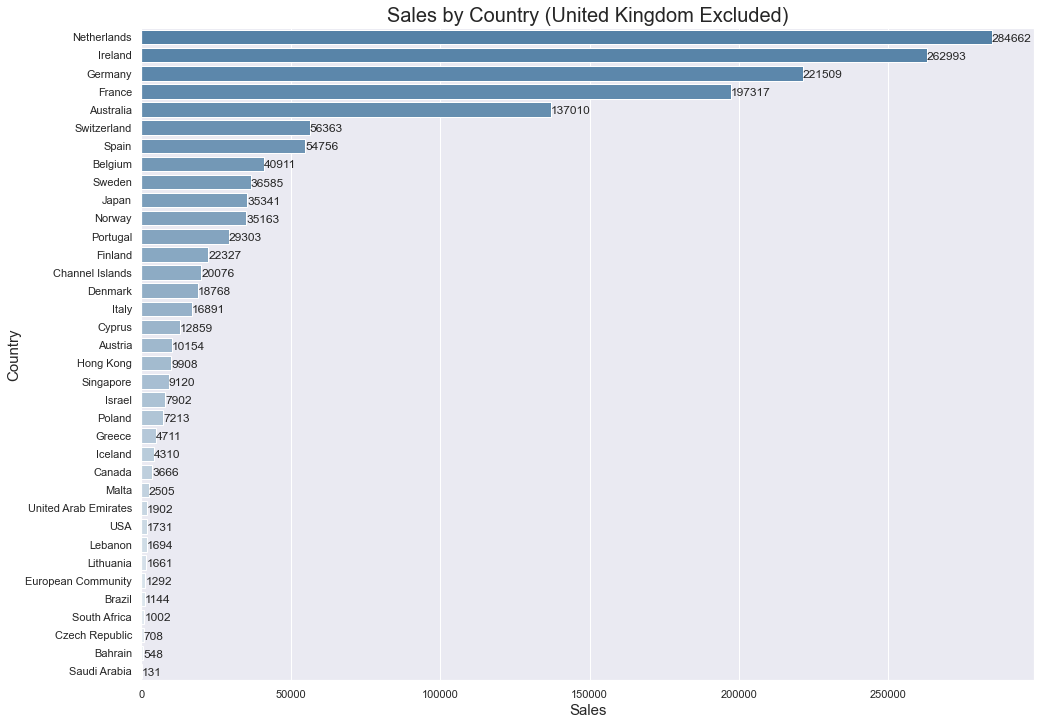

In [22]:
# Sales by Countries other than United Kingdom
plotdata = Sales_by_Country.reset_index()
other_country_order = plotdata.loc[1:].Country.to_list()
current_palette = sns.light_palette('steelblue', n_colors = len(other_country_order), reverse = True)
fig, ax = plt.subplots(figsize = (16,12))
ax = sns.barplot(y = plotdata.loc[1:].Country, 
                 x = plotdata.loc[1:].Amount, 
                 order = other_country_order,
                 palette = current_palette)
ax.set_xlabel('Sales',fontsize = 15)
ax.set_ylabel('Country',fontsize = 15)
ax.set_title('Sales by Country (United Kingdom Excluded)',fontsize = 20)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(width + 1, p.get_y()+(height/1.25),s = '{:.0f}'.format(width) ,ha = "left")
plt.show()

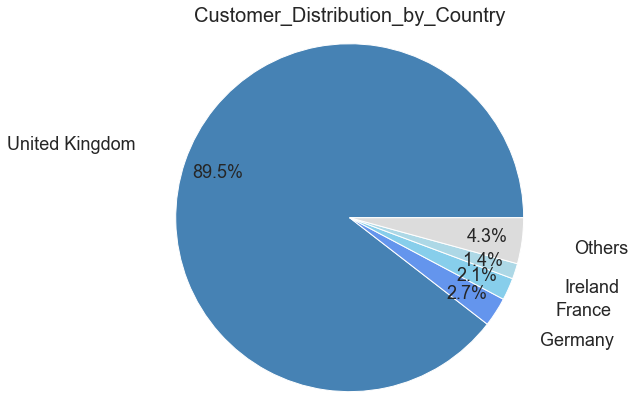

In [23]:
# Customer Distribution by Country

Customer_Dist_by_Ctry = ecommerce_new.groupby(by='Country').agg({'CustomerID':'count'})
Customer_Dist_by_Ctry = Customer_Dist_by_Ctry.sort_values('CustomerID',ascending = False)
Customer_Dist_by_Ctry['Percentage'] = Customer_Dist_by_Ctry.CustomerID/sum(Customer_Dist_by_Ctry.CustomerID)
Customer_Dist_by_Ctry_Major = Customer_Dist_by_Ctry[Customer_Dist_by_Ctry.Percentage >= 0.01]
# Combine all other countries 
Customer_Dist_by_Ctry_Others = Customer_Dist_by_Ctry[Customer_Dist_by_Ctry.Percentage < 0.01]
Others = {'CustomerID':sum(Customer_Dist_by_Ctry_Others.CustomerID),
          'Percentage':sum(Customer_Dist_by_Ctry_Others.Percentage)}
Others_index = {'Others'}
Others = pd.DataFrame(Others, index = Others_index)
# New DataFrame for analyzing Sales by Country
Customer_Dist_by_Ctry_Major = Customer_Dist_by_Ctry_Major.append(Others)

# pie plot
colors = ['steelblue', 'cornflowerblue', 'skyblue', 'lightblue', 'gainsboro']
fig, ax = plt.subplots(figsize = (5,5))
plt.pie(Customer_Dist_by_Ctry_Major.CustomerID, 
        colors = colors,
        autopct = '%.1f%%',  
        textprops = {'fontsize': 18},
        labeldistance = 1.3, 
        pctdistance = 0.8, 
        labels = Customer_Dist_by_Ctry_Major.index, 
        radius = 1.6)

plt.title('Customer_Distribution_by_Country',y = 1.2, fontsize = 20)
plt.show()

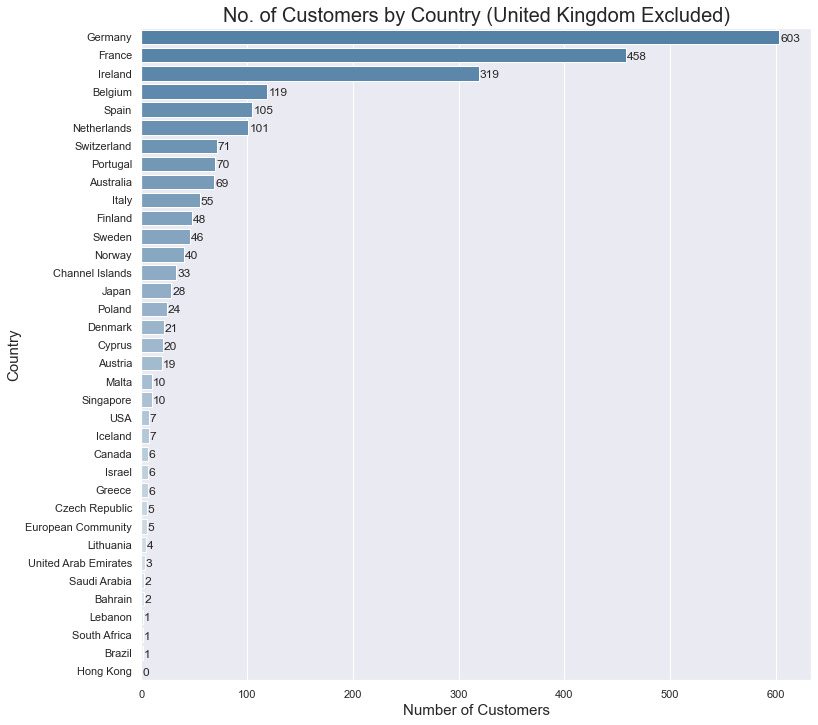

In [24]:
# Customer Distribution by Countries other than United Kingdom
plotdata = Customer_Dist_by_Ctry.reset_index()
other_country_order = plotdata.loc[1:].Country.to_list()
current_palette = sns.light_palette('steelblue', n_colors = len(other_country_order), reverse = True)
fig, ax = plt.subplots(figsize = (12,12))
ax = sns.barplot(y = plotdata.loc[1:].Country, 
                 x = plotdata.loc[1:].CustomerID, 
                 order = other_country_order,
                 palette = current_palette)
ax.set_xlabel('Number of Customers',fontsize = 15)
ax.set_ylabel('Country',fontsize = 15)
ax.set_title('No. of Customers by Country (United Kingdom Excluded)',fontsize = 20)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(width + 1, p.get_y()+(height/1.25),s = '{:.0f}'.format(width), ha = "left")
plt.show()

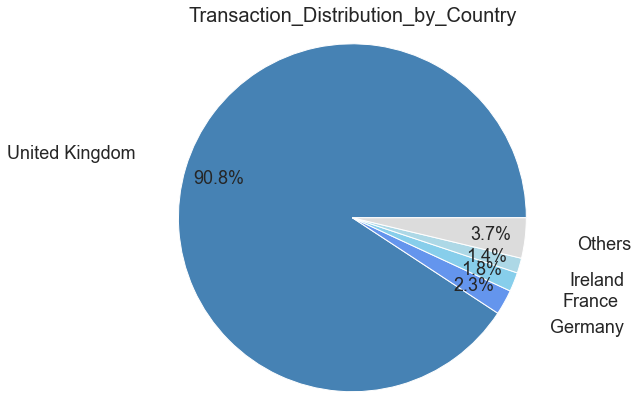

In [25]:
# Transaction_Distribution_by_Country
Trans_Dist_by_Ctry = ecommerce_new.groupby(by = 'Country').agg({'InvoiceNo':'count'})
Trans_Dist_by_Ctry = Trans_Dist_by_Ctry.sort_values('InvoiceNo',ascending = False)
Trans_Dist_by_Ctry['Percentage'] = Trans_Dist_by_Ctry.InvoiceNo/sum(Trans_Dist_by_Ctry.InvoiceNo)
Trans_Dist_by_Ctry_Major = Trans_Dist_by_Ctry[Trans_Dist_by_Ctry.Percentage >= 0.01]
# Combine all other countries 
Trans_Dist_by_Ctry_Others = Trans_Dist_by_Ctry[Trans_Dist_by_Ctry.Percentage < 0.01]
Others = {'InvoiceNo':sum(Trans_Dist_by_Ctry_Others.InvoiceNo),
          'Percentage':sum(Trans_Dist_by_Ctry_Others.Percentage)}
Others_index = {'Others'}
Others = pd.DataFrame(Others, index = Others_index)
# New DataFrame for analyzing Sales by Country
Trans_Dist_by_Ctry_Major = Trans_Dist_by_Ctry_Major.append(Others)
# pie plot
colors = ['steelblue', 'cornflowerblue', 'skyblue', 'lightblue', 'gainsboro']
fig, ax = plt.subplots(figsize = (5,5))
plt.pie(Trans_Dist_by_Ctry_Major.InvoiceNo, 
        colors = colors,
        autopct = '%.1f%%',  
        textprops = {'fontsize': 18},
        labeldistance = 1.3, 
        pctdistance = 0.8, 
        labels = Customer_Dist_by_Ctry_Major.index, 
        radius = 1.6)

plt.title('Transaction_Distribution_by_Country',y = 1.2,fontsize = 20)
plt.show()

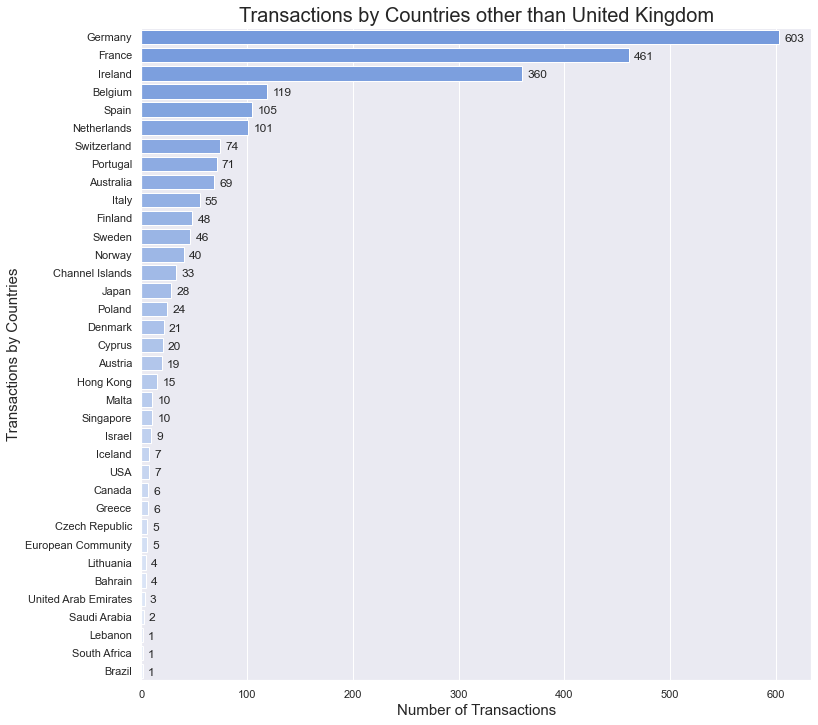

In [26]:
# Transaction Counts by Countries other than United Kingdom
Trans_by_Ctry = ecommerce[['Country','InvoiceNo']].drop_duplicates()\
                                                  .groupby(['Country'])\
                                                  .agg({'InvoiceNo':'count'})\
                                                  .sort_values(by = 'InvoiceNo', ascending = False)

Trans_by_Ctry = Trans_by_Ctry.reset_index().rename(columns = {'InvoiceNo':'Transactions'})
Trans_by_Ctry['Percentage'] = Trans_by_Ctry.Transactions/Trans_by_Ctry.Transactions.sum()
Trans_by_Ctry.head()
other_country_order = Trans_by_Ctry.Country.loc[1:].to_list()

# Plot
current_palette = sns.light_palette('cornflowerblue', n_colors = Trans_by_Ctry.Country.shape[0]-1, reverse = True)
fig, ax = plt.subplots(figsize = (12,12))
ax = sns.barplot(y = Trans_by_Ctry.loc[1:].Country, 
                 x = Trans_by_Ctry.Transactions, 
                 order = other_country_order,
                 palette = current_palette)
ax.set_xlabel('Number of Transactions',fontsize = 15)
ax.set_ylabel('Transactions by Countries',fontsize = 15)
ax.set_title('Transactions by Countries other than United Kingdom',fontsize = 20)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(width + 5, p.get_y() + (height/1.25),s = '{:.0f}'.format(width) ,ha = "left")
plt.show()

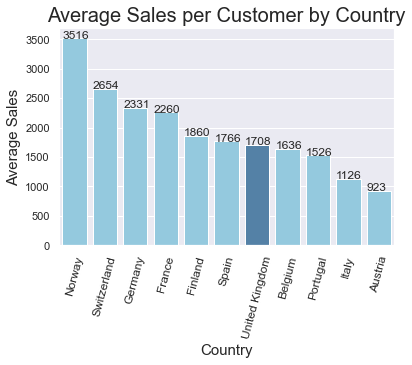

In [27]:
Customer_Ctry = ecommerce_new[['Country', 'CustomerID','Amount']].dropna()\
                                                                 .groupby(['Country'])\
                                                                 .agg({'CustomerID':'nunique','Amount':'sum'})\
                                                                 .rename(columns = {'CustomerID':'Customer_Count', 
                                                                                    'Amount':'Customer_Sales'})\
                                                                 .sort_values(by = 'Customer_Count', 
                                                                              ascending = False)
# Remove countries in which the company has only few customers
Customer_Ctry = Customer_Ctry[Customer_Ctry.Customer_Count > 9]                                                               
Customer_Ctry['Sales_per_Customer'] = Customer_Ctry['Customer_Sales']/Customer_Ctry.Customer_Count
Customer_Ctry = Customer_Ctry.sort_values(by='Sales_per_Customer', ascending = False)
country_order = Customer_Ctry.index.to_list()
country_color = {}
for i in country_order:
    if i == 'United Kingdom':
        country_color[i] = 'steelblue'
    else:
        country_color[i] = 'skyblue'

fig, ax = plt.subplots()
ax = sns.barplot(y = Customer_Ctry.Sales_per_Customer, 
                 x = Customer_Ctry.index, 
                 order = country_order, 
                 palette = country_color)
ax.set_xlabel('Country',fontsize = 15)
ax.set_ylabel('Average Sales',fontsize = 15)
ax.set_title('Average Sales per Customer by Country',fontsize = 20)
plt.xticks(rotation = 75,fontsize = 12)
for p in ax.patches:
    ax.annotate('{}'.format(str(int(p.get_height()))), (p.get_x(), p.get_height()))


## InvoiceDate & Time Analysis

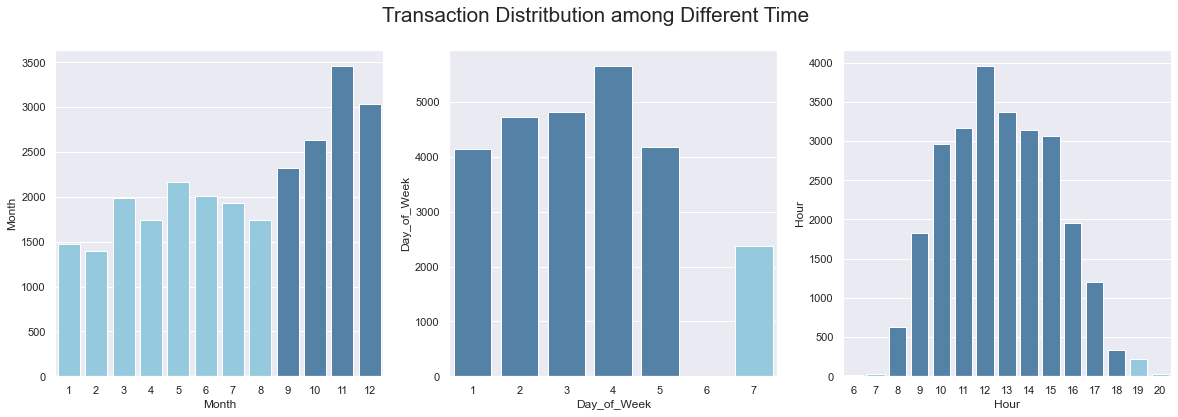

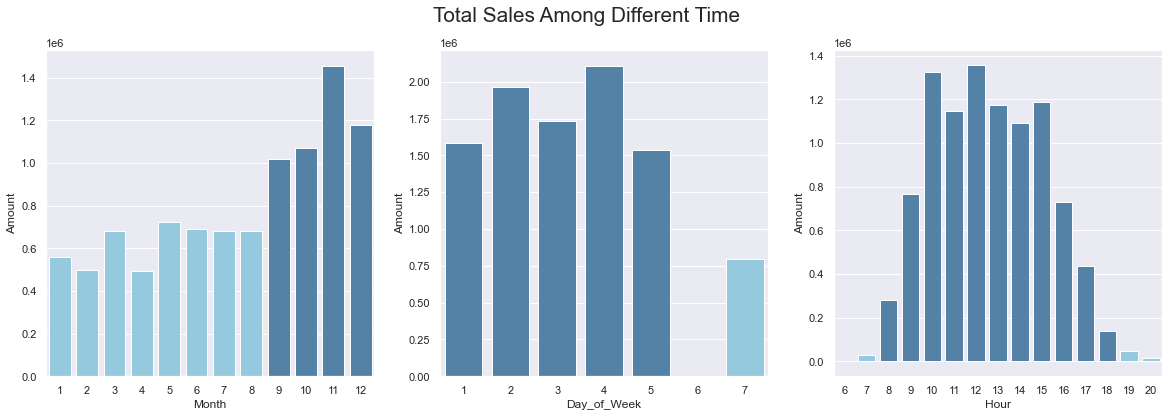

In [40]:
# Number of Transactions by occurring time
Month_Sales = ecommerce_new.groupby('Month').agg({'Amount':'sum','Month':'count'})
Day_of_Week_Sales = ecommerce_new.groupby('Day_of_Week').agg({'Amount':'sum','Day_of_Week':'count'})
Hour_Sales = ecommerce_new.groupby('Hour').agg({'Amount':'sum','Hour':'count'})

month_order = range(1, 13)
day_of_week_order = range(1, 8)
hour_order = range(6, 21)

fig, axes = plt.subplots(1,3, figsize=(20, 6))
plt.suptitle('Transaction Distritbution among Different Time', fontsize = 'xx-large')

# Transaction counts by transaction time
color_month = ['skyblue' for x in range(8)] + ['steelblue' for x in range(4)]
color_day_of_week = ['steelblue' for x in range(5)] + ['skyblue' for x in range(2)]
color_hour = ['skyblue' for x in range(2)] + ['steelblue' for x in range(11)] + ['skyblue' for x in range(2)]
sns.barplot(x = Month_Sales.index, 
            y = Month_Sales.Month,
            order = month_order,
            palette = color_month,
            ax = axes[0])
sns.barplot(x = Day_of_Week_Sales.index,
            y = Day_of_Week_Sales.Day_of_Week,
            order = day_of_week_order,
            palette = color_day_of_week,
            ax = axes[1])
sns.barplot(x = Hour_Sales.index,
            y = Hour_Sales.Hour,
            order = hour_order,
            palette = color_hour,
            ax = axes[2])

# Sales by transaction time
fig, axes = plt.subplots(1,3, figsize = (20, 6))
plt.suptitle('Total Sales Among Different Time', fontsize = 'xx-large')
sns.barplot(x = Month_Sales.index, 
            y = Month_Sales.Amount, 
            palette = color_month,
            order = month_order,
            ax = axes[0])
sns.barplot(x = Day_of_Week_Sales.index, 
            y = Day_of_Week_Sales.Amount, 
            palette = color_day_of_week,
            order = day_of_week_order, 
            ax=axes[1])
sns.barplot(x = Hour_Sales.index, 
            y = Hour_Sales.Amount, 
            palette = color_hour,
            order = hour_order, 
            ax = axes[2])
plt.show()

# <center>Customer Analysis</center>

# Data Cleaning

### <li>Important Customers</li>

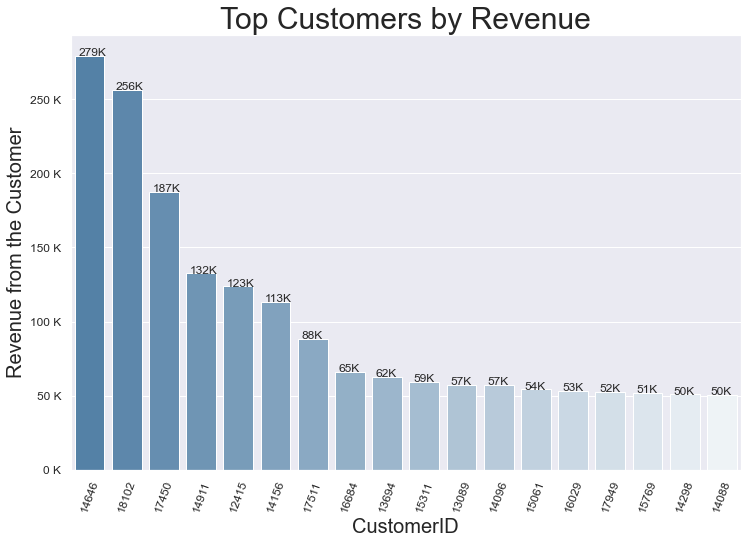

In [41]:
# Sales by Cusotomers
Sales_by_Client = ecommerce_new.groupby(by= 'CustomerID').agg({'Amount':'sum'})
Sales_by_Client = Sales_by_Client[Sales_by_Client.Amount > 0]
Sales_by_Client['Amount_Percentage'] = Sales_by_Client.Amount/sum(Sales_by_Client.Amount)

# Find important_Client(who contributes more than 0.5% of sales)
Important_Clients = Sales_by_Client[Sales_by_Client.Amount_Percentage >= 0.005]
Important_Clients = Important_Clients.sort_values(by = 'Amount_Percentage',ascending=False)

current_palette =sns.light_palette('steelblue', n_colors = Important_Clients.shape[0], reverse = True)

fig, ax = plt.subplots(figsize = (12,8))
ax = sns.barplot(x = Important_Clients.index, 
                 y = Important_Clients['Amount'], 
                 order = Important_Clients.index, 
                 palette = current_palette)

ylabels = ['{}'.format(int(x)) + ' K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels, fontsize = 12)
plt.xticks(rotation = 70,fontsize = 12)
plt.xlabel('CustomerID', fontsize = 20)
plt.ylabel('Revenue from the Customer', fontsize = 20)
plt.title('Top Customers by Revenue', fontsize = 30)

for p in ax.patches:
    ax.annotate('{}'.format(str(int(p.get_height()/1000)) + 'K'), (p.get_x()+0.1, p.get_height()+0.1))

plt.show()


### RFM

In [42]:
from statistics import multimode
# Extract information for RFM model
ecommerce_new.StockCode = ecommerce_new.StockCode.apply(list)

RFM = ecommerce_new.sort_values(by = 'New_InvoiceDate', ascending = False)\
                   .groupby(['CustomerID'])\
                   .agg({'Days_since_Transaction':['max', 'min'],
                         'CustomerID':'count',
                         'Amount': 'sum',
                         'StockCode':['sum','first']})

RFM.columns = ['Days_since_First_Transaction','R','F','M','StockCode_List','Items_Bought_Recently']
RFM['StockCode_List'] = RFM.StockCode_List.apply(lambda x: [i for i in x if (i not in invaid_stockcode)])
RFM['Items_Bought_Recently'] = RFM.Items_Bought_Recently\
                                  .apply(lambda x: [i for i in x if (i not in invaid_stockcode)])
RFM['Items_Bought_Most'] = RFM.StockCode_List.apply(lambda x: list(multimode(x)))


RFM.StockCode_List = RFM.StockCode_List.apply(lambda x: x.pop() if len(x) == 1 else x)
RFM.StockCode_List = RFM.StockCode_List.apply(lambda x: np.nan if len(x) == 0 else x)
RFM.Items_Bought_Most = RFM.Items_Bought_Most.apply(lambda x: x.pop() if len(x) == 1 else x)
RFM.Items_Bought_Most = RFM.Items_Bought_Most.apply(lambda x: np.nan if len(x) == 0 else x)
RFM.Items_Bought_Recently = RFM.Items_Bought_Recently.apply(lambda x: x.pop() if len(x) == 1 else x)
RFM.Items_Bought_Recently = RFM.Items_Bought_Recently.apply(lambda x: np.nan if len(x) == 0 else x)


null_list = RFM[RFM.Items_Bought_Recently.isnull()].index.to_list()
Items_Bought_Recently = ecommerce[ecommerce.CustomerID.isin(null_list)]

Items_Bought_Recently = Items_Bought_Recently.dropna(subset = ['New_StockCode'])\
                       .sort_values(by = 'InvoiceDate')\
                       .groupby('CustomerID')\
                       .agg({'StockCode':'last'})

Items_Bought_Recently = Items_Bought_Recently.StockCode.to_dict()
RFM = RFM.reset_index()
RFM.Items_Bought_Recently = RFM.Items_Bought_Recently.fillna(RFM.CustomerID.map(Items_Bought_Recently))

RFM.head()

,CustomerID,Days_since_First_Transaction,R,F,M,StockCode_List,Items_Bought_Recently,Items_Bought_Most
0,12346,326,326,2,0.00,"[23166, 23166]",23166,23166
1,12347,367,2,7,4310.00,"[20719, 21064, 21265, 21731, 23084, 23271, 234...","[20719, 21064, 21265, 21731, 23084, 23271, 234...",22375
2,12348,358,75,4,1797.24,"[23077, 23078, 22437, 23076, 23077, 23078, 217...","[23077, 23078]","[23077, 23078, 21213, 21977, 22952, 84991]"
3,12349,19,19,1,1757.55,"[20685, 20914, 21086, 21136, 21231, 21232, 214...","[20685, 20914, 21086, 21136, 21231, 21232, 214...","[20685, 20914, 21086, 21136, 21231, 21232, 214..."
4,12350,310,310,1,334.40,"[20615, 20652, 21171, 21832, 21864, 21866, 219...","[20615, 20652, 21171, 21832, 21864, 21866, 219...","[20615, 20652, 21171, 21832, 21864, 21866, 219..."


In [43]:
# Assign R score, F score, M score, RFM Tier and RFM Score to each customer based on their behavior
n= 5 # tier numbers
R_labels = range(n,0,-1)
F_labels = range(1,n+1)
M_labels = range(1,n+1)
weight = [1,1,1]
# F_Score:
def f_class(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x <= 4:
        return 3
    elif x <= 6:
        return 4
    else:
        return 5

RFM['R_Score'] = pd.qcut(RFM['R'], n, labels= R_labels)
# RFM['F_Score'] = pd.qcut(RFM['F'], n+1, duplicates='drop')
RFM['M_Score'] = pd.qcut(RFM['M'], n, labels = F_labels)
RFM['F_Score'] = RFM.F.apply(f_class)

RFM['RFM_Tier'] = RFM.apply(lambda x: str(x.R_Score) + str(x.F_Score) + str(x.M_Score), axis = 1)
RFM['RFM_Score'] = RFM.apply(lambda x: x.R_Score * weight[0] + x.F_Score * weight[1] + x.M_Score * weight[2],
                             axis = 1)
# Change the dtype of collumns for future calculation
RFM.R_Score = RFM.R_Score.astype(int)
RFM.F_Score = RFM.F_Score.astype(int)
RFM.M_Score = RFM.M_Score.astype(int)
RFM.RFM_Score = RFM.RFM_Score.astype(int)

RFM_Statistics = RFM.groupby('RFM_Score').agg({'R':'mean',
                                               'F':'mean',
                                               'M':['mean','count']}).round(0).astype(int)
RFM.head()

,CustomerID,Days_since_First_Transaction,R,F,M,StockCode_List,Items_Bought_Recently,Items_Bought_Most,R_Score,M_Score,F_Score,RFM_Tier,RFM_Score
0,12346,326,326,2,0.00,"[23166, 23166]",23166,23166,1,1,2,121,4
1,12347,367,2,7,4310.00,"[20719, 21064, 21265, 21731, 23084, 23271, 234...","[20719, 21064, 21265, 21731, 23084, 23271, 234...",22375,5,5,5,555,15
2,12348,358,75,4,1797.24,"[23077, 23078, 22437, 23076, 23077, 23078, 217...","[23077, 23078]","[23077, 23078, 21213, 21977, 22952, 84991]",2,4,3,234,9
3,12349,19,19,1,1757.55,"[20685, 20914, 21086, 21136, 21231, 21232, 214...","[20685, 20914, 21086, 21136, 21231, 21232, 214...","[20685, 20914, 21086, 21136, 21231, 21232, 214...",4,4,1,414,9
4,12350,310,310,1,334.40,"[20615, 20652, 21171, 21832, 21864, 21866, 219...","[20615, 20652, 21171, 21832, 21864, 21866, 219...","[20615, 20652, 21171, 21832, 21864, 21866, 219...",1,2,1,112,4


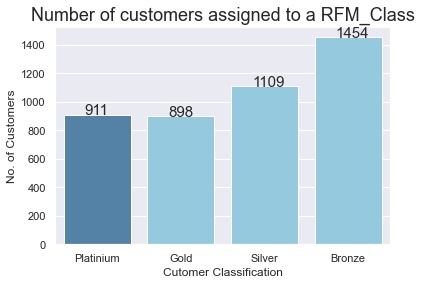

In [44]:
# RFM_Model Distribution
def rfm_classification(x):
    if x.RFM_Score > 12:
        return 'Platinium'
    elif x.RFM_Score > 9:
        return 'Gold'
    elif x.RFM_Score > 6:
        return 'Silver'
    else:
        return 'Bronze' 

RFM['RFM_Class'] = RFM.apply(rfm_classification,axis = 1)
rfm_class_order = ['Platinium','Gold','Silver','Bronze']

rfm_color = {'Platinium':'steelblue', 'Gold':'skyblue','Silver':'skyblue','Bronze':'skyblue'}
plt.figure()
ax = sns.countplot(RFM.RFM_Class, order = rfm_class_order, palette = rfm_color)
ax.set_title('Number of customers assigned to a RFM_Class', fontsize = 18)
ax.set_ylabel('No. of Customers')
ax.set_xlabel('Cutomer Classification')
ax.tick_params(axis = 'both')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+ 0.25, p.get_height()+0.2), fontsize = 15)

plt.show()

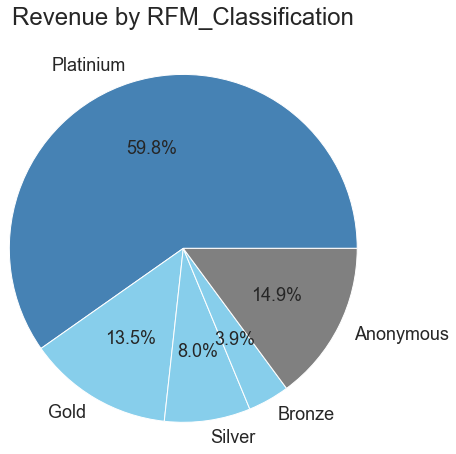

In [45]:
# Sales Contributions of each RFM_Class
RFM_Statistics = RFM.groupby('RFM_Class').agg({'M':'sum'}).sort_values(by ='M',ascending=False)
RFM_Statistics.loc['Anonymous'] = ecommerce[ecommerce.CustomerID.isnull()].Amount.sum()

rfm_labels = ['Platinium', 'Gold', 'Silver', 'Bronze','Anonymous']
rfm_colors = ['steelblue','skyblue','skyblue', 'skyblue','grey']
plt.pie(RFM_Statistics.M, 
        radius = 2, 
        autopct = '%.1f%%', 
        colors = rfm_colors, 
        pctdistance = 0.6, 
        textprops = {'fontsize': 18},
        labels = rfm_labels)
plt.title('Revenue by RFM_Classification',fontsize = 24, y = 1.5)

plt.show()

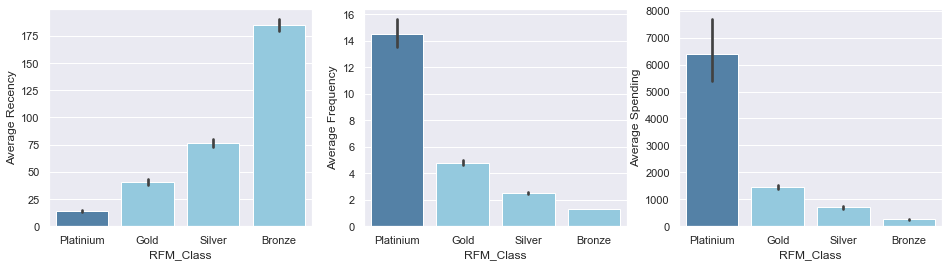

In [46]:
# RFM Segmentation Visualization
rfm_class_order = ['Platinium', 'Gold', 'Silver', 'Bronze']
rfm_color = {'Platinium':'steelblue', 'Gold':'skyblue','Silver':'skyblue','Bronze':'skyblue'}
fig, axes = plt.subplots(1,3,figsize=(16,4))
sns.barplot(x = 'RFM_Class', y = 'R', data = RFM, ax = axes[0], order = rfm_class_order, palette = rfm_color)
axes[0].set_ylabel('Average Recency')

sns.barplot(x = 'RFM_Class', y = 'F', data = RFM, ax = axes[1], order = rfm_class_order, palette = rfm_color)
axes[1].set_ylabel('Average Frequency')

sns.barplot(x = 'RFM_Class', y = 'M', data = RFM, ax = axes[2], order = rfm_class_order, palette = rfm_color)
axes[2].set_ylabel('Average Spending')

plt.show()

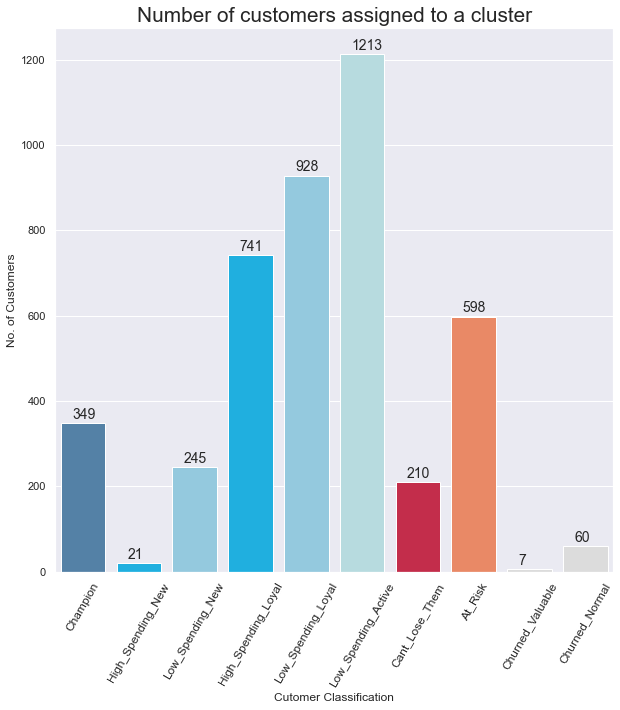

In [47]:
# New Customers
RFM.loc[RFM['Days_since_First_Transaction'] <= 30, 'New_or_Not'] = 1
RFM.New_or_Not = RFM.New_or_Not.fillna(0)
RFM.New_or_Not.value_counts()

# Best(Champion) Customers
RFM.loc[(RFM['R_Score']>= 5) 
        & (RFM['F_Score']>= 5) 
        & (RFM['M_Score']>= 5), 'Classification'] = 'Champion'


# High Spending New Customers
RFM['Classification'] = RFM.apply(lambda row: 'High_Spending_New' 
                                      if pd.isnull(row['Classification']) 
                                          and (row.New_or_Not == 1) 
                                          and (row['M_Score']>= 4)
                                      else row['Classification'], axis = 1)

# Low Spending New Customers
RFM['Classification'] = RFM.apply(lambda row: 'Low_Spending_New' 
                                      if pd.isnull(row['Classification']) 
                                          and (row.New_or_Not == 1) 
                                          and (row['M_Score']<= 3)
                                      else row['Classification'], axis = 1)

# Churned Best Customers
RFM['Classification'] = RFM.apply(lambda row: 'Churned_Valuable' 
                                      if pd.isnull(row['Classification']) 
                                          and (row['R'] > 365)
                                          and (row['M_Score'] >= 3)
                                      else row['Classification'], axis = 1)
# Churned Normal Customers
RFM['Classification'] = RFM.apply(lambda row: 'Churned_Normal' 
                                      if pd.isnull(row['Classification']) 
                                          and (row['R'] > 365)
                                      else row['Classification'], axis = 1)


# High Loyal Customers
RFM['Classification'] = RFM.apply(lambda row: 'High_Spending_Loyal' 
                                      if pd.isnull(row['Classification']) 
                                          and (row['R_Score'] >= 3) 
                                          and (row['F_Score'] >= 4) 
                                          and (row['M_Score'] >= 4)
                                      else row['Classification'], axis = 1)

# Low spending Loyal Customers
RFM['Classification'] = RFM.apply(lambda row: 'Low_Spending_Loyal' 
                                      if pd.isnull(row['Classification']) 
                                          and (row['R_Score'] >= 3) 
                                          and (row['F_Score'] >= 2) 
                                          and (row['M_Score'] >= 2)
                                      else row['Classification'], axis = 1)
# Customers Needing Attention
RFM['Classification'] = RFM.apply(lambda row: 'Low_Spending_Active' 
                                      if pd.isnull(row['Classification']) 
                                          and (row['R_Score'] >= 2) 
                                      else row['Classification'], axis = 1)   
# Can't Lose Them
RFM['Classification'] = RFM.apply(lambda row: 'Cant_Lose_Them' 
                                      if pd.isnull(row['Classification']) 
                                          and (row['M_Score'] >= 3)
                                      else row['Classification'], axis = 1)


# At Risk
RFM['Classification'] = RFM.apply(lambda row: 'At_Risk' 
                                      if pd.isnull(row['Classification']) 
                                          and (row['R_Score'] == 1)  
                                      else row['Classification'], axis=1)

# Other Customers
RFM.loc[RFM.Classification.isnull(),'Classification'] ='Other'

cutomer_classification_order = ['Champion',
                                'High_Spending_New',
                                'Low_Spending_New',
                                'High_Spending_Loyal',
                                'Low_Spending_Loyal', 
                                'Low_Spending_Active',
                                'Cant_Lose_Them',
                                'At_Risk',
                                'Churned_Valuable',
                                'Churned_Normal']
cutomer_classification_color = {'Champion':'steelblue',
                                'High_Spending_New':'deepskyblue',
                                'Low_Spending_New':'skyblue',
                                'High_Spending_Loyal':'deepskyblue',
                                'Low_Spending_Loyal':'skyblue', 
                                'Low_Spending_Active': 'powderblue',
                                'Cant_Lose_Them':'crimson',
                                'At_Risk':'coral',
                                'Churned_Valuable':'gainsboro',
                                'Churned_Normal':'gainsboro',
                                'Others': 'gainsboro'}

fig, ax = plt.subplots(figsize = ((10,10)))
ax = sns.countplot(RFM.Classification, 
                   order = cutomer_classification_order, 
                   palette = cutomer_classification_color)
plt.title('Number of customers assigned to a cluster', fontsize = 'xx-large')
ax.set_xlabel('Cutomer Classification')
ax.set_ylabel('No. of Customers')
plt.xticks(fontsize=12)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.2, p.get_height()+10),fontsize = 14)

ax.tick_params(axis = 'x', labelrotation = 60,labelleft = True)
plt.show()

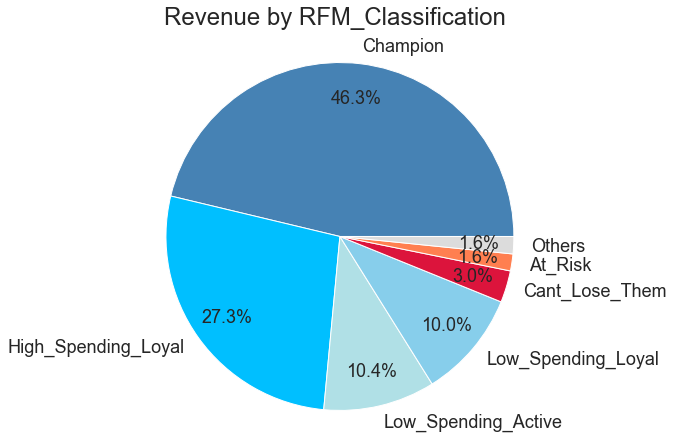

In [48]:
# Sales Contributions of each RFM_Class
Cutomer_Classification = RFM.groupby('Classification')\
                            .agg({'M':'sum', 'Classification':'count'})\
                            .sort_values(by ='M',ascending=False)
Cutomer_Classification['M_percentage'] = Cutomer_Classification['M'] / RFM.M.sum()
cutomer_classification = Cutomer_Classification.M_percentage.to_dict()


plotdict = dict((k,v) for k,v in cutomer_classification.items() if v >= 0.01)
others = sum(v for k,v in cutomer_classification.items() if v < 0.01)
plotdict['Others'] = others

color_list = []
for i in plotdict.keys():
    color_list.append(cutomer_classification_color[i])

plt.pie([float(v) for v in plotdict.values()], 
        radius = 2, 
        autopct = '%.1f%%', 
        pctdistance = 0.8, 
        textprops = {'fontsize': 18},
        labels = [v for v in plotdict.keys()], 
        colors = color_list
       )
plt.suptitle('Revenue by RFM_Classification',fontsize = 24, y = 1.3)
plt.show()

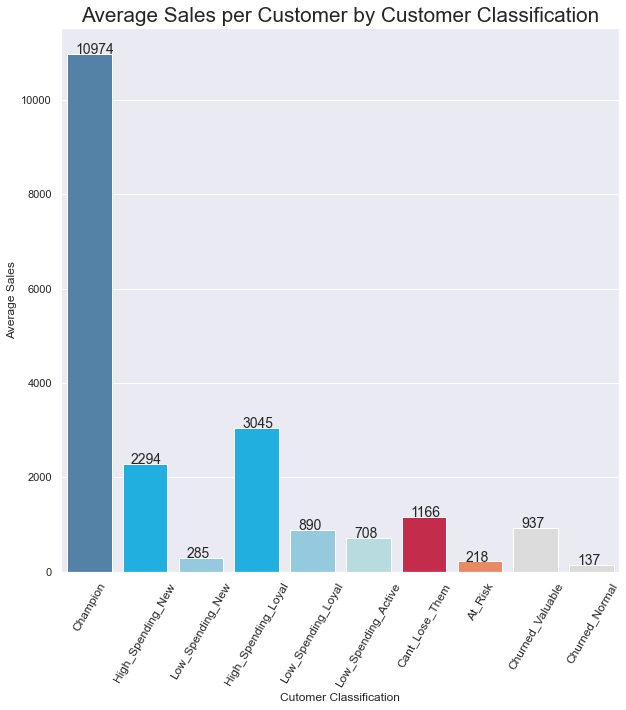

In [49]:
Cutomer_Classification['Avg_Sales'] = Cutomer_Classification.M / Cutomer_Classification.Classification

fig, ax = plt.subplots(figsize=((10,10)))
ax = sns.barplot(x= Cutomer_Classification.index, 
                 y = Cutomer_Classification.Avg_Sales,
                 palette = cutomer_classification_color,
                 order = cutomer_classification_order)

plt.title('Average Sales per Customer by Customer Classification',fontsize='xx-large')
plt.xticks(fontsize = 12)
for p in ax.patches:
    ax.annotate('{}'.format(int(p.get_height().round(0))), (p.get_x() + 0.15, p.get_height()),fontsize = 14)
ax.set_xlabel('Cutomer Classification')
ax.set_ylabel('Average Sales')
ax.tick_params(axis = 'x',labelrotation = 60,labelleft = True)
plt.show()

## RFM-Kmeans

### Check Outliers
<p>Outliers has huge impact on Kmeans Clustering. Therefore, we have to find outliers and remove them when using Kmeans.</p>

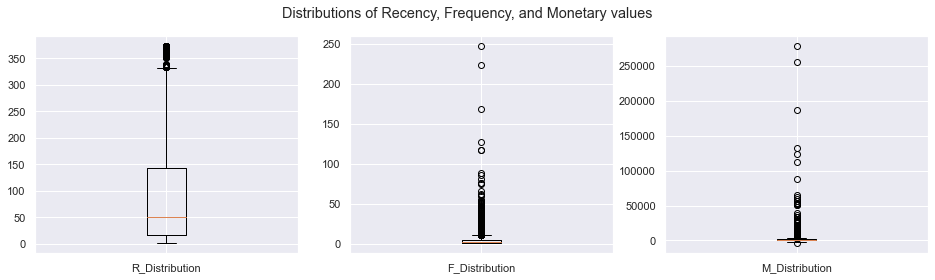

In [50]:
# show outliers
fig, axs = plt.subplots(1, 3,figsize=(16,4))
axs[0].boxplot(RFM.R)

axs[1].boxplot(RFM.F) 
axs[2].boxplot(RFM.M)

axs[0].set_xticklabels(['R_Distribution'])
axs[1].set_xticklabels(['F_Distribution'])
axs[2].set_xticklabels(['M_Distribution'])
plt.suptitle('Distributions of Recency, Frequency, and Monetary values') 
plt.show()

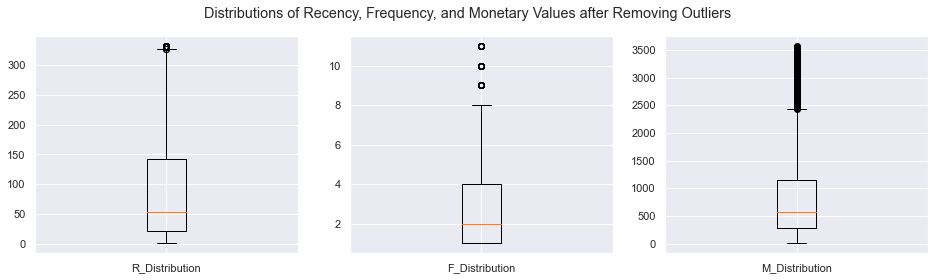

In [51]:
RFM_Kmeans = RFM[RFM.M>0].copy()
# DELETE Outlier for R
Q1 = RFM.R.quantile(0.25)
Q3 = RFM.R.quantile(0.75)
IQR = Q3 - Q1
RFM_Kmeans = RFM_Kmeans[(RFM_Kmeans.R >= (Q1 - 1.5 * IQR)) & (RFM_Kmeans.R <= (Q3 + 1.5 * IQR))]

# DELETE Outlier for F
Q1 = RFM.F.quantile(0.25)
Q3 = RFM.F.quantile(0.75)
IQR = Q3 - Q1
RFM_Kmeans = RFM_Kmeans[(RFM_Kmeans.F >= (Q1-1.5*IQR)) & (RFM_Kmeans.F <= (Q3 + 1.5 * IQR))]

# DELETE Outlier for M
Q1 = RFM.M.quantile(0.25)
Q3 = RFM.M.quantile(0.75)
IQR = Q3 - Q1
RFM_Kmeans = RFM_Kmeans[(RFM_Kmeans.M >= (Q1 - 1.5 * IQR)) & (RFM_Kmeans.M < (Q3 + 1.5 * IQR))]

fig, axs = plt.subplots(1, 3,figsize=(16,4))
axs[0].boxplot(RFM_Kmeans.R)
axs[1].boxplot(RFM_Kmeans.F)
axs[2].boxplot(RFM_Kmeans.M)
axs[0].set_xticklabels(['R_Distribution'])
axs[1].set_xticklabels(['F_Distribution'])
axs[2].set_xticklabels(['M_Distribution'])
plt.suptitle('Distributions of Recency, Frequency, and Monetary Values after Removing Outliers') 
plt.show()


## Normalization/Standardisation

In [52]:
# Prepared data for K-Means
RFM_Norm = RFM_Kmeans[['R','F','M']].copy()
# Standardisation
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_Norm = standard_scaler.fit_transform(RFM_Norm)
RFM_Norm = pd.DataFrame(RFM_Norm)
RFM_Norm.columns = ['R','F','M']
RFM_Norm

,R,F,M
0,-0.174740,0.354313,1.266269
1,-0.795911,-0.891763,1.214131
2,2.431958,-0.891763,-0.655360
3,-0.607341,3.261825,0.935458
4,1.256171,-0.891763,-0.977725
...,...,...,...
3642,-0.185832,-0.891763,-0.866198
3643,2.077004,-0.891763,-0.857397
3644,1.001047,-0.891763,-0.988470
3645,-0.917926,-0.061045,-0.862651


# Test how good the data can be clustered

<body> Hopkins Statistics is a way of measuring the cluster tendency of a data set. The result ranges from 0 to 1 with  uniformly distributed data at near 0,random data at near 0.5, highly clustered data at near 1. If we have a result larger than 0.7, we believe the dataset is clustered.
</body>


In [53]:
# Hopkins Statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

# Hopkins Function Coding
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis = 0),
                                            np.amax(X,axis = 0),
                                            d).reshape(1, -1), 2, return_distance = True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance = True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

# Apply Hopkins Statistics for RFM_Norm
if hopkins(RFM_Norm) > 0.7:
    print('The hopkins statistic value is ' + str(hopkins(RFM_Norm).round(2))
          +', the data is highly clustered.')

The hopkins statistic value is 0.9, the data is highly clustered.


# Check how many clusters is optimal

<body> We use Elbow Method, Silhouette Analysis and Calinski-Harabaz Index to find the optimal number of clusters. Elbow Method consists of plotting the explained variation as a function of the number of clusters, and choosing the elbow of the curve as the number of clusters to use. Silhouette Analysis and Calinski-Harabaz Index are used to measure how similar an object is to its own cluster compared to other clusters. Higher values indicate better clustering.
</body>


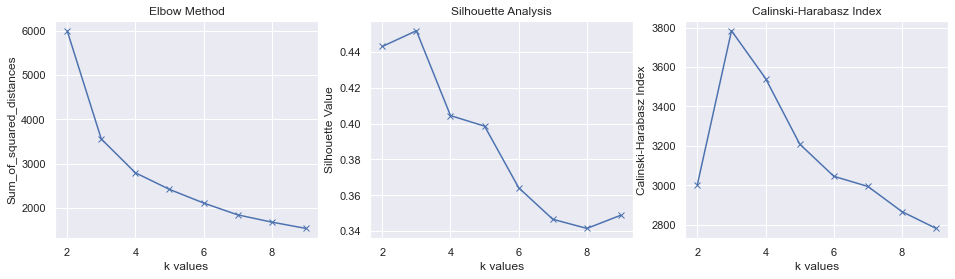

In [54]:
# Elbow Method, Silhouette Analysis & Calinski-Harabaz Index
'''The silhouette ranges from −1 to +1,
where a high value indicates that the object is well matched to its own cluster
and poorly matched to neighboring clusters. If most objects have a high value,
then the clustering configuration is appropriate.  
If many points have a low or negative value, 
then the clustering configuration may have too many or too few clusters

Higher scores means the differences for items inside a cluster is smaller
while difference between clusters is huger
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
Sum_of_squared_distances = []
s_scores = []
c_scores = []
clusters = range(2,10)
for k in clusters:
    kmeans = KMeans(n_clusters = k).fit(RFM_Norm)
    Sum_of_squared_distances.append(kmeans.inertia_)#for Elbow Method  
    s_score = silhouette_score(RFM_Norm,kmeans.labels_)
    s_scores.append(s_score)# Silhouette Analysis
    c_score = calinski_harabasz_score(RFM_Norm, kmeans.labels_)
    c_scores.append(c_score)#for Calinski-Harabaz Index:

fig, axs= plt.subplots(1,3,figsize=(16,4))
axs[0].plot(clusters,Sum_of_squared_distances,'-x')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('k values')
axs[0].set_ylabel('Sum_of_squared_distances')

axs[1].plot(clusters,s_scores,'-x')
axs[1].set_title('Silhouette Analysis')
axs[1].set_xlabel('k values')
axs[1].set_ylabel('Silhouette Value')

axs[2].plot(clusters,c_scores,'-x')
axs[2].set_title('Calinski-Harabasz Index')
axs[2].set_xlabel('k values')
axs[2].set_ylabel('Calinski-Harabasz Index')


plt.show()

For n_clusters = 2 The average silhouette_score is : 0.443088436242907


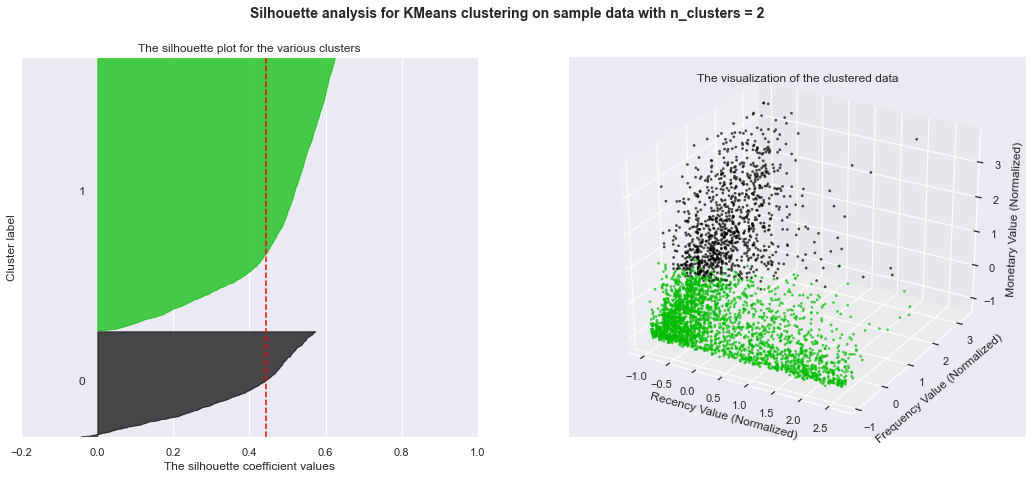

For n_clusters = 3 The average silhouette_score is : 0.4518862483237561


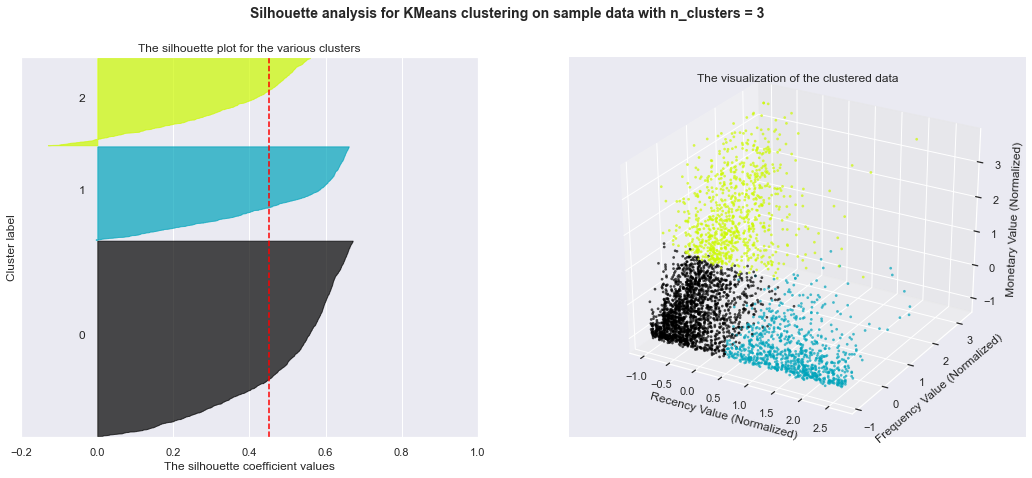

For n_clusters = 4 The average silhouette_score is : 0.40359571054633137


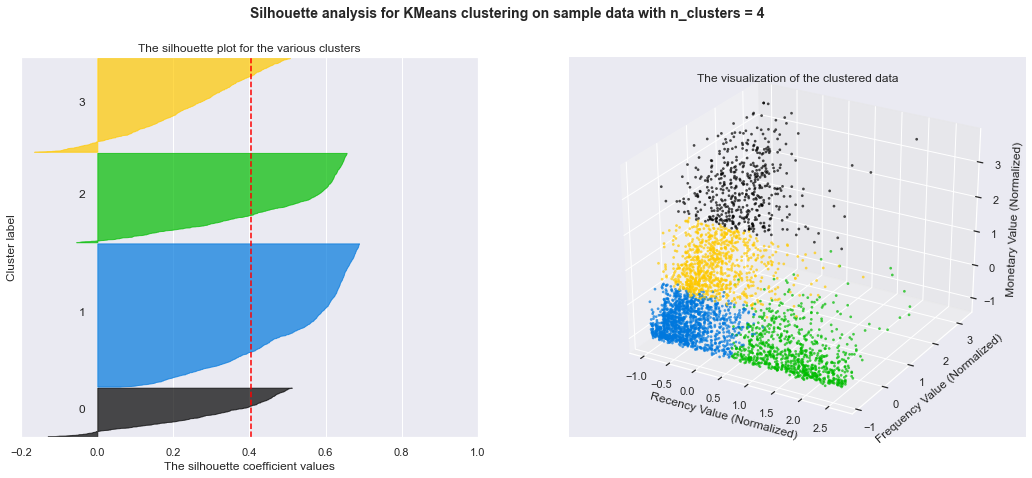

For n_clusters = 5 The average silhouette_score is : 0.4003289844167274


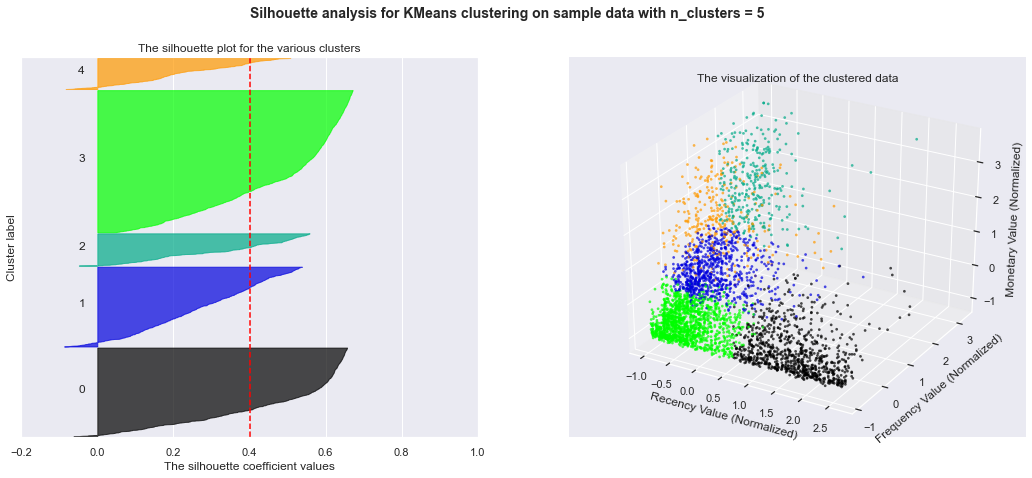

For n_clusters = 6 The average silhouette_score is : 0.3641478106678053


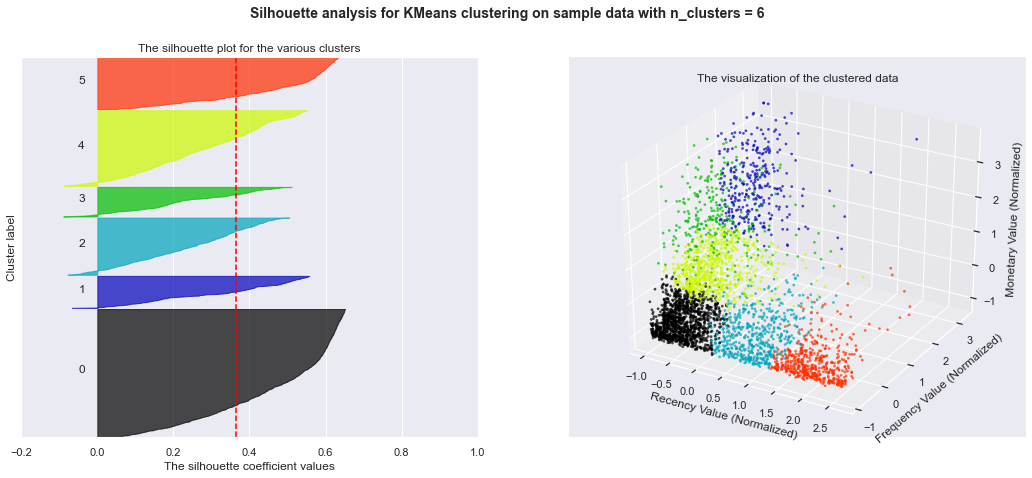

In [55]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples = 500,
                  n_features = 2,
                  centers = 4,
                  cluster_std=1,
                  center_box = (-10.0, 10.0),
                  shuffle = True,
                  random_state = 1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but our data all lie within [-0.2, 1]
    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(RFM_Norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(RFM_Norm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(RFM_Norm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(RFM_Norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor = color, edgecolor = color, alpha = 0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x = silhouette_avg, color = "red", linestyle = "--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax = fig.add_subplot(1, 2, 2, projection = '3d')
    ax.scatter3D(RFM_Norm.R, 
                 RFM_Norm.F, 
                 RFM_Norm.M, 
                 marker='.', 
                 s = 30, 
                 lw = 0, 
                 alpha = 0.7,
                 c = colors, 
                 edgecolor = 'k')

    ax.set_title("The visualization of the clustered data")
    ax.set_xlabel("Recency Value (Normalized)")
    ax.set_ylabel("Frequency Value (Normalized)")
    ax.set_zlabel("Monetary Value (Normalized)")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize = 14, 
                 fontweight = 'bold')

    plt.show()

# Apply Kmeans with optimal k

In [66]:
# We use k = 3 (based on Elbow method, Silhouette analysis, & Calinski-Harabaz Index)
kmeans = KMeans(n_clusters=3).fit(RFM_Norm)
RFM_Kmeans = RFM_Kmeans.assign(Kmeans_Original = kmeans.labels_)
# Distribution of each clusters
RFM_Kmeans_Statistics = RFM_Kmeans.groupby('Kmeans_Original')\
                                  .agg({'R':'mean','F':'mean','M':['mean','count']})\
                                  .astype(int)\
                                  .sort_values(('M','mean'),ascending = False)
RFM_Kmeans_Statistics

R    F     M      
                mean mean  mean count
Kmeans_Original                      
2                 37    6  1920   847
1                 48    2   555  1898
0                229    1   398   902

In [67]:
# Rename Kmeans Cluster
kmeans_dict = {}
n = 0
for idx in RFM_Kmeans_Statistics.index:
    kmeans_dict[idx] = n
    n += 1
        
kmeans_3_classificaiton = {0:'High_Spending_Loyal',1:'Low_Spending_Loyal',2:'Low_Spending_Active'}
RFM_Kmeans['Cluster_ID'] = RFM_Kmeans['Kmeans_Original'].map(kmeans_dict)
RFM_Kmeans['Kmeans_Classification'] = RFM_Kmeans['Cluster_ID'].map(kmeans_3_classificaiton)

#Final DataFrame for# RFM_and_Kmeans
RFM_and_Kmeans = RFM.merge(RFM_Kmeans.Kmeans_Classification, 
                           how = 'left',
                           left_index = True,
                           right_index = True
                          )
RFM_and_Kmeans.head()

,CustomerID,Days_since_First_Transaction,R,F,M,StockCode_List,Items_Bought_Recently,Items_Bought_Most,R_Score,M_Score,F_Score,RFM_Tier,RFM_Score,RFM_Class,New_or_Not,Classification,Kmeans_Classification
0,12346,326,326,2,0.00,"[23166, 23166]",23166,23166,1,1,2,121,4,Bronze,0.0,At_Risk,NaN
1,12347,367,2,7,4310.00,"[20719, 21064, 21265, 21731, 23084, 23271, 234...","[20719, 21064, 21265, 21731, 23084, 23271, 234...",22375,5,5,5,555,15,Platinium,0.0,Champion,NaN
2,12348,358,75,4,1797.24,"[23077, 23078, 22437, 23076, 23077, 23078, 217...","[23077, 23078]","[23077, 23078, 21213, 21977, 22952, 84991]",2,4,3,234,9,Silver,0.0,Low_Spending_Active,High_Spending_Loyal
3,12349,19,19,1,1757.55,"[20685, 20914, 21086, 21136, 21231, 21232, 214...","[20685, 20914, 21086, 21136, 21231, 21232, 214...","[20685, 20914, 21086, 21136, 21231, 21232, 214...",4,4,1,414,9,Silver,1.0,High_Spending_New,Low_Spending_Loyal
4,12350,310,310,1,334.40,"[20615, 20652, 21171, 21832, 21864, 21866, 219...","[20615, 20652, 21171, 21832, 21864, 21866, 219...","[20615, 20652, 21171, 21832, 21864, 21866, 219...",1,2,1,112,4,Bronze,0.0,At_Risk,Low_Spending_Active


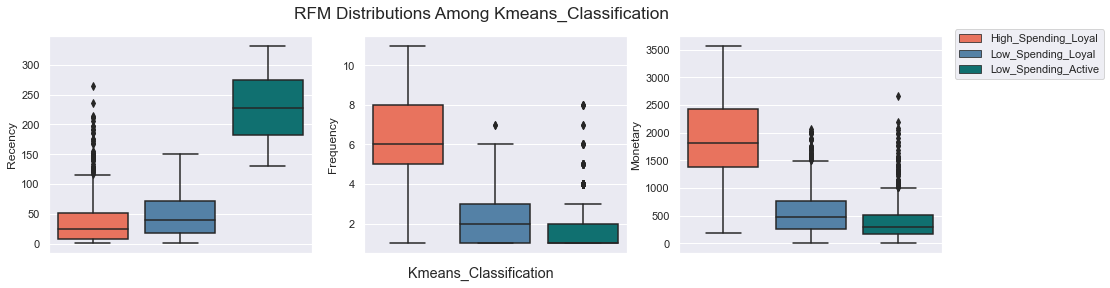

In [68]:
# R, F and M distribution among Clusters
kmeans_order = ['High_Spending_Loyal','Low_Spending_Loyal','Low_Spending_Active']
kmeans_color = {'High_Spending_Loyal':'tomato','Low_Spending_Loyal':'steelblue','Low_Spending_Active':'teal'}
fig, axes = plt.subplots(1,3, figsize=(16,4))
sns.boxplot(x = 'Kmeans_Classification', 
            y = 'R', data = RFM_and_Kmeans, 
            order = kmeans_order, 
            palette = kmeans_color, 
            hue = 'Kmeans_Classification',
            dodge = False,
            ax = axes[0])
sns.boxplot(x ='Kmeans_Classification', 
            y = 'F', 
            data = RFM_and_Kmeans, 
            order = kmeans_order, 
            palette = kmeans_color, 
            hue = 'Kmeans_Classification',
            dodge = False,
            ax = axes[1])
plt.xticks(rotation = 75,fontsize = 12)
sns.boxplot(x ='Kmeans_Classification', 
            y = 'M', 
            data = RFM_and_Kmeans, 
            order = kmeans_order, 
            palette = kmeans_color, 
            hue = 'Kmeans_Classification',
            dodge = False,
            ax = axes[2])
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[2].set_xticks([])
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[0].set_ylabel('Recency')
axes[1].set_ylabel('Frequency')
axes[2].set_ylabel('Monetary')
plt.xticks(rotation = 75,fontsize = 12)

h, l = axes[0].get_legend_handles_labels()

# remove all the subplot legends
for ax in axes: ax.get_legend().remove()

# add one legend on `plt`
plt.legend(h,l, loc = (1.05, 0.8))
fig.text(0.5, 0.04, 'Kmeans_Classification', ha = 'center', fontsize = 'large')

plt.suptitle('RFM Distributions Among Kmeans_Classification',fontsize = 'x-large')
plt.show()

In [69]:
# Check RFM_distributions
RFM_Distribution = RFM_and_Kmeans.drop(columns = ['R_Score',
                                                  'M_Score',
                                                  'F_Score',
                                                  'RFM_Score',
                                                  'RFM_Tier',
                                                  'RFM_Class'])
RFM_Distribution = RFM_Distribution.groupby('Kmeans_Classification').agg({'R':['min','max','mean'],
                                                                          'F':['min','max','mean'],
                                                                          'M':['min','max','mean','count']})
RFM_Distribution

R                    F                     M  \
                       min  max        mean min max      mean     min   
Kmeans_Classification                                                   
High_Spending_Loyal      1  264   37.610390   1  11  6.571429  191.17   
Low_Spending_Active    131  332  229.456763   1   8  1.735033    3.75   
Low_Spending_Loyal       1  151   48.551633   1   7  2.289779    2.90   

                                                   
                           max         mean count  
Kmeans_Classification                              
High_Spending_Loyal    3574.91  1920.358596   847  
Low_Spending_Active    2661.24   398.031530   902  
Low_Spending_Loyal     2062.06   555.032220  1898

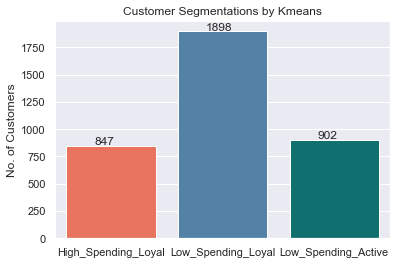

In [70]:
# Number of each cluster
customers_by_kmeans = RFM_and_Kmeans.loc[(~RFM_and_Kmeans['Kmeans_Classification'].isnull())]

kmeans_order = ['High_Spending_Loyal','Low_Spending_Loyal','Low_Spending_Active']
kmeans_color = {'High_Spending_Loyal':'tomato','Low_Spending_Loyal':'steelblue','Low_Spending_Active':'teal'}
ax = sns.countplot(customers_by_kmeans.Kmeans_Classification, order = kmeans_order, palette = kmeans_color)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+8))
ax.set(xlabel = '', ylabel = 'No. of Customers',title =  'Customer Segmentations by Kmeans')

plt.show()

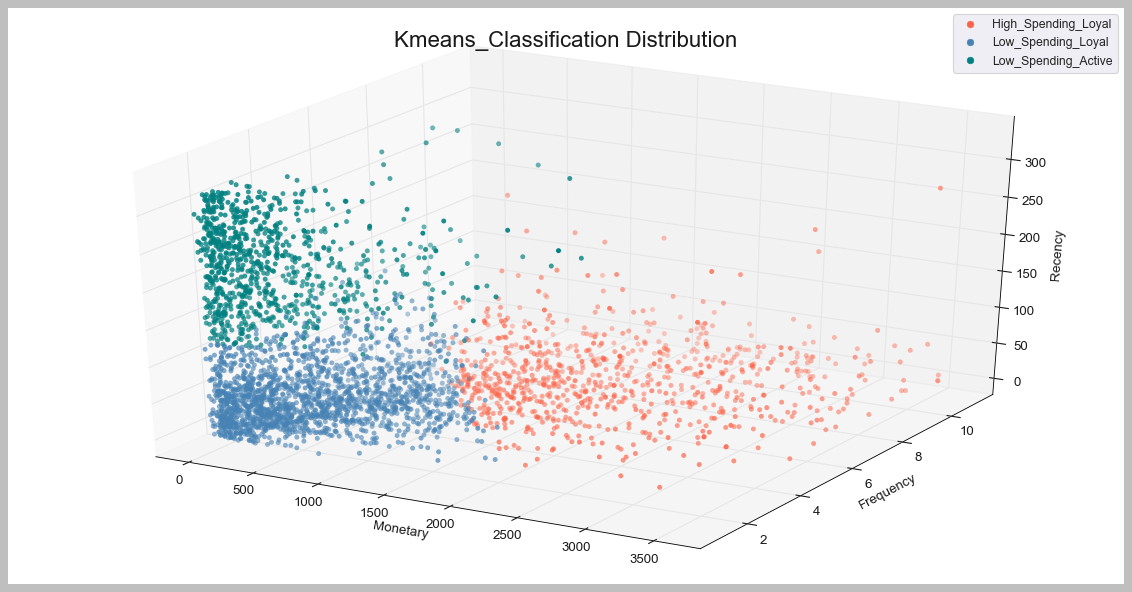

In [71]:
# Kmeans plot
figdata = RFM_and_Kmeans.loc[(~RFM_and_Kmeans['Kmeans_Classification'].isnull())]
kmeans_color = {'High_Spending_Loyal':'tomato','Low_Spending_Loyal':'steelblue','Low_Spending_Active':'teal'}

with plt.style.context('classic'):
    fig = plt.figure(figsize = (18,9))
    ax = plt.axes(projection = '3d')
    markers = [plt.Line2D([0,0],
                          [0,0],
                          color = color, 
                          marker = 'o', 
                          linestyle = '') for color in kmeans_color.values()]
    ax.scatter3D(figdata['M'], 
                 figdata['F'],
                 figdata['R'],
                 linewidth = 0 ,
                 c = figdata['Kmeans_Classification'].apply(lambda x:kmeans_color[x]))
    ax.set_xlabel('Monetary')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Recency')

plt.title('Kmeans_Classification Distribution', fontsize = 20)
plt.legend(markers, kmeans_color.keys(), numpoints = 1)
plt.show()

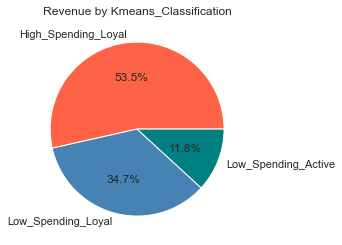

In [72]:
# Sales Contributions of each Kmeans_Classification
Kmeans_Statistics = RFM_and_Kmeans.groupby('Kmeans_Classification')\
                                  .agg({'M':'sum'})\
                                  .sort_values(by = 'M',ascending = False)
kmeans_labels = ['High_Spending_Loyal','Low_Spending_Loyal','Low_Spending_Active']
kmeans_colors = ['tomato','steelblue','teal']
plt.pie(Kmeans_Statistics.M, autopct = '%.1f%%', colors = kmeans_colors, labels = kmeans_labels)
plt.title('Revenue by Kmeans_Classification')
plt.show()

In [65]:
# Change datatype and Date output
ecommerce_RFM = ecommerce_new.merge(RFM_and_Kmeans, left_on = 'CustomerID', right_on = 'CustomerID', how = 'left')
ecommerce_RFM['CustomerID'] = ecommerce_RFM['CustomerID'].astype(str).replace('nan', np.nan)
ecommerce_RFM['Year'] = ecommerce_RFM['Year'].astype(int)
ecommerce_RFM['Month'] = ecommerce_RFM['Month'].astype(int)
ecommerce_RFM['Day_of_Week'] = ecommerce_RFM['Day_of_Week'].astype(int)
ecommerce_RFM['Hour'] = ecommerce_RFM['Hour'].astype(int)
ecommerce_RFM['RFM_Tier'] = ecommerce_RFM['RFM_Tier'].astype(str).replace('nan', np.nan)
ecommerce_RFM['RFM_Score'] = ecommerce_RFM['RFM_Score'].astype(str).replace('nan', np.nan)
ecommerce_RFM['RFM_Class'] = ecommerce_RFM['RFM_Class'].astype(str).replace('nan', np.nan)
ecommerce_RFM['Kmeans_Classification'] = ecommerce_RFM['Kmeans_Classification'].astype(str).replace('nan', np.nan)
ecommerce_RFM.dtypes
ecommerce_RFM.to_csv('ecommerce_RFM.csv')